In [70]:
# Load relevant R packages
inLibraries = list('repr','rgdal','rgeos','spdep','classInt')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))      
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)


## Crime

This time, let's look at some crime data.  There are a wide variety of sources of crime data that are publically available and easy to access. For instance, I did a websearch for crime data and found Chicago posts current crimes in a .csv file format (Chicago Crime data https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f). There are actually a large amount of crimes in this dataset, so I took a subset (those reported for Oct. 2016). In order to associate a topology with the crime data, I found some US Census Blockgroups for the state of Illinois (https://www.census.gov/geo/maps-data/data/cbf/cbf_blkgrp.html). Next, I created a point featureclass from the .csv file since it contained latitude/longitude fields and associated both the crime and blockgroup features with the same coordinate reference system. Finally, I joined the two datasets such that each blockgroup now has a field containing the number of burglaries in Oct. 2016 (Burglaries) and a field containing the total number of crimes in Oct. 2016 (AllCrime).  

In [71]:
#Your code for task 1 goes here.

blockGroup <- readOGR("datasets/chicago",
                      "ChicagoBurglaryOct2016")

chiPoly <- readOGR("datasets/chicago",
                      "ChicagoBoundary")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/chicago", layer: "ChicagoBurglaryOct2016"
with 9689 features
It has 13 fields
Integer64 fields read as strings:  TARGET_FID Burglaries AllCrime 
OGR data source with driver: ESRI Shapefile 
Source: "datasets/chicago", layer: "ChicagoBoundary"
with 77 features
It has 9 fields


In [72]:
peekBG <- head(blockGroup@data)

t(peekBG)

,0,1,2,3,4,5
TARGET_FID,0,1,2,3,4,5
STATEFP,17,17,17,17,17,17
COUNTYFP,031,019,031,111,119,203
TRACTCE,010100,005300,811301,871109,403121,030200
BLKGRPCE,3,1,4,1,3,3
AFFGEOID,1500000US170310101003,1500000US170190053001,1500000US170318113014,1500000US171118711091,1500000US171194031213,1500000US172030302003
GEOID,170310101003,170190053001,170318113014,171118711091,171194031213,172030302003
NAME,3,1,4,1,3,3
LSAD,BG,BG,BG,BG,BG,BG
ALAND,133973,3095432,1626156,1485802,5445376,1391057


In [73]:
peekPoly <- head(chiPoly@data)

t(peekPoly)

,0,1,2,3,4,5
perimeter,0,0,0,0,0,0
community,DOUGLAS,OAKLAND,FULLER PARK,GRAND BOULEVARD,KENWOOD,LINCOLN SQUARE
shape_len,31027.05,19565.51,25339.09,28196.84,23325.17,36624.60
shape_area,46004621,16913961,19916705,48492503,29071742,71352328
area,0,0,0,0,0,0
comarea,0,0,0,0,0,0
area_numbe,35,36,37,38,39,4
area_num_1,35,36,37,38,39,4
comarea_id,0,0,0,0,0,0


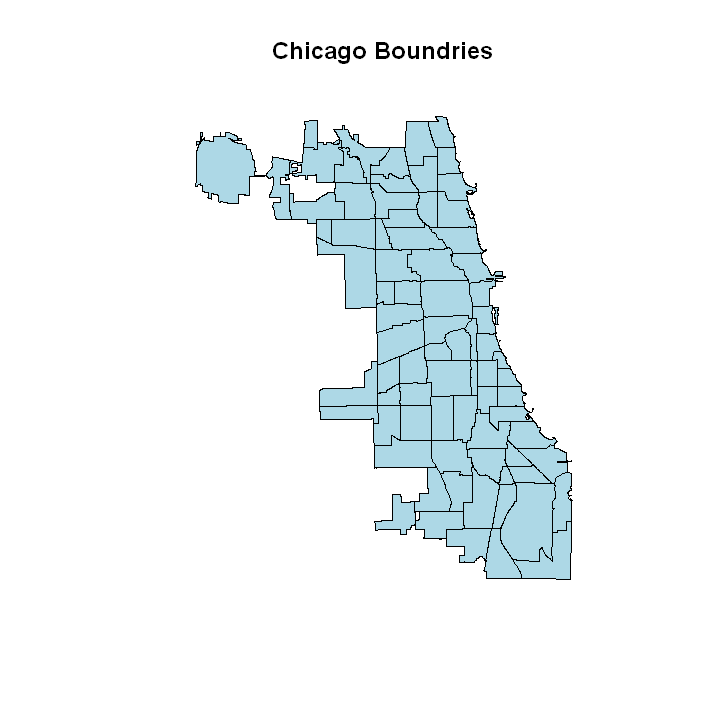

In [74]:
plot(chiPoly, col = "lightblue", lwd = 0.2, main = "Chicago Boundries")

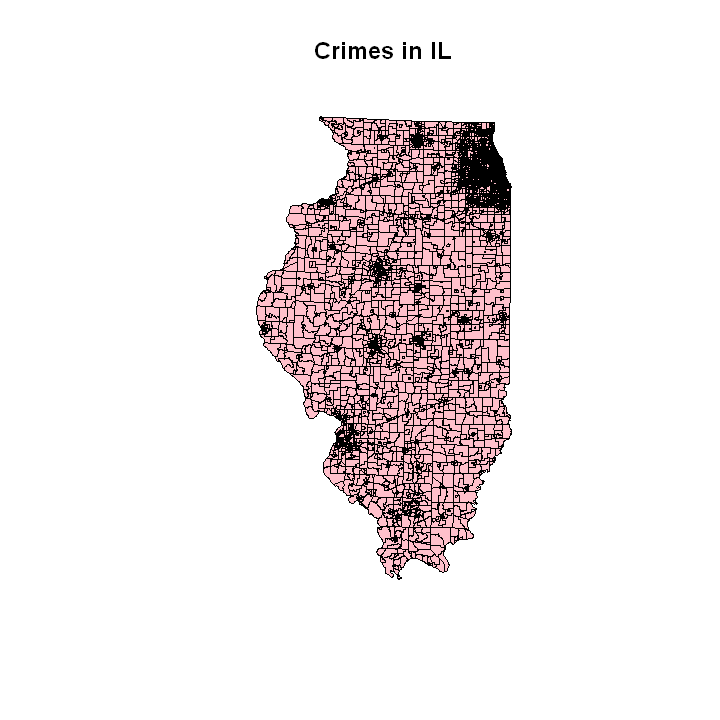

In [75]:
plot(blockGroup, col = "pink", lwd = 0.2, main = "Crimes in IL")

 Given that the blockgroup data is for the entire state of Illinois and the crime is only for the Chicago area, you should refine the set of polygons that will be retained for analysis. This is why the boundary file for Chicago is provided. 

In [76]:
selFeat <- overGeomGeom(chiPoly, blockGroup, 
                            returnList =  TRUE, 
                            fn = NULL)

In [77]:
typeof(selFeat)

[1] "list"

In [78]:
intSet <- unlist(selFeat)

In [79]:
print(paste("There are ", length(intSet)," intersecting features"))

[1] "There are  3553  intersecting features"


In [80]:
intFeat <- blockGroup[intSet, ]

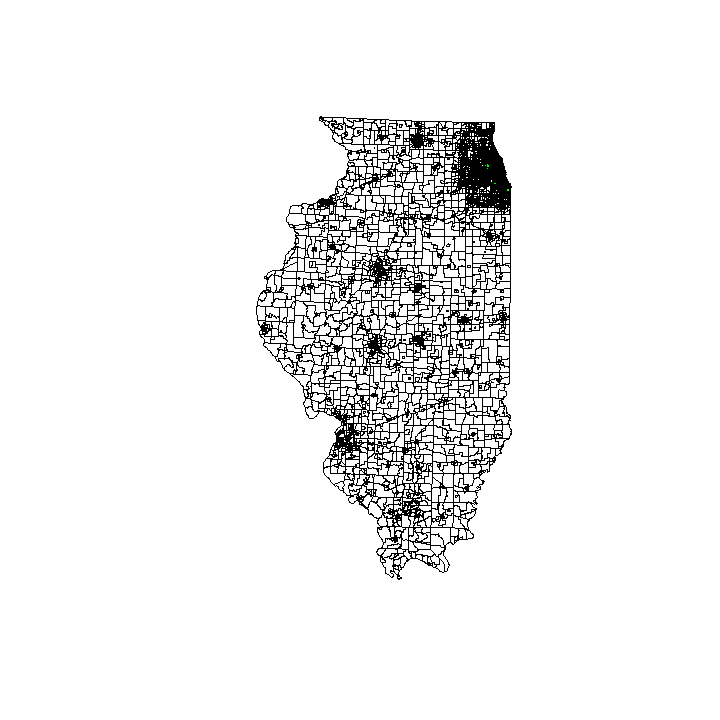

In [81]:
plot(blockGroup, col = "white", lwd = 0.2)
plot(intFeat, add = TRUE, col = "green")

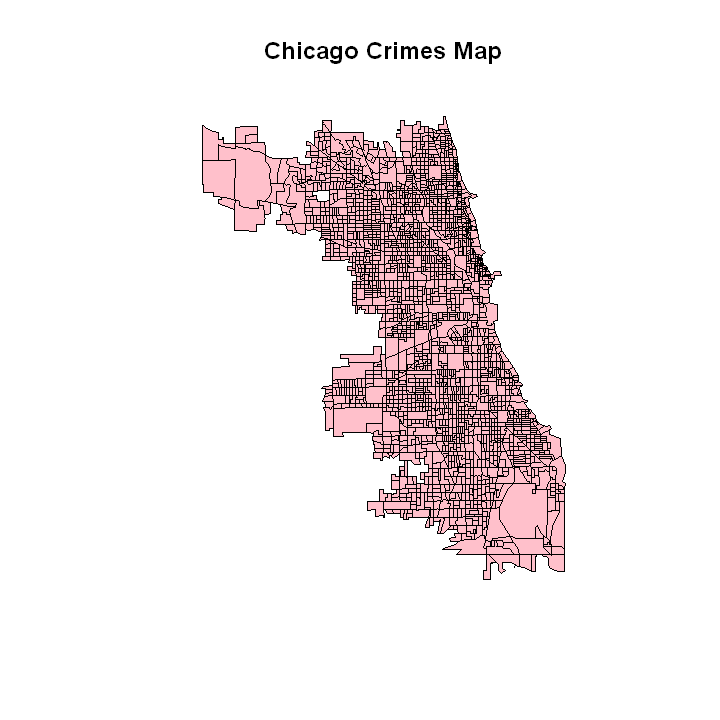

In [82]:
plot(intFeat, col = "pink", lwd = 0.2, main = "Chicago Crimes Map")

In [83]:
# Generate a spdep neighborhood object for the selected blockgroups.

chi.nb <- poly2nb(intFeat, queen = TRUE)

chi.nb

Neighbour list object:
Number of regions: 3553 
Number of nonzero links: 46088 
Percentage nonzero weights: 0.3650879 
Average number of links: 12.97157 

In [84]:
head(chi.nb)

[[1]]
[1]  6  7 31 32 33 42 93

[[2]]
 [1]    9   13   20   29   55   76   80  100 1680 1688 1692 1699 2599

[[3]]
 [1]    4    8    9   10   17   20   21   22   25   28   41   72   76   97 1671
[16] 1692

[[4]]
 [1]   3  11  22  28  30  36  41  46  97 103

[[5]]
 [1]   12   15   19   20   23 1653 1664 1667 1672 1683 1685 1689 1692 1694 1700
[16] 2613 2619

[[6]]
 [1]   1   7  11  16  22  30  31  32  33  36  39  41  42  46  47  82  93 103 104

Should a feature have no neighbors, problems may arise in the computation of measures that are premised on the assumption that a valid neighborhood exists for a feature.
Given this:

a) check the neighborhoods for features and only retain those features that have a valid neighborhood,

b) generate the neighborhoods for the areas that have valid neighborhoods again applying the Queen's criterion, and

c) transform the neighborhoods into neighborhood lists.

In [85]:
length(chi.nb)

[1] 3553

In [86]:
#  check the neighborhoods for features 
# and only retain those features that 
# have a valid neighborhood

chi.subset <- intFeat[card(chi.nb) >= 1, ]

In [87]:
length(chi.subset)

[1] 3553

In [88]:
# generate the neighborhoods for the areas that have valid 
# neighborhoods again applying the Queen's criterion, 

chi.subset.nb <- poly2nb(chi.subset, queen = TRUE)

chi.subset.nb

Neighbour list object:
Number of regions: 3553 
Number of nonzero links: 46088 
Percentage nonzero weights: 0.3650879 
Average number of links: 12.97157 

In [89]:
#  transform the neighborhoods into neighborhood lists.

chi.subset.listb <- nb2listw(chi.subset.nb, style = "B")
chi.subset.listw <- nb2listw(chi.subset.nb, style = "W")

In [90]:
names(chi.subset.listb)

[1] "style"      "neighbours" "weights"

In [91]:
head(chi.subset.listb$weights)

[[1]]
[1] 1 1 1 1 1 1 1

[[2]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1

[[3]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[4]]
 [1] 1 1 1 1 1 1 1 1 1 1

[[5]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[6]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [92]:
head(chi.subset.listb$neighbours)

[[1]]
[1]  6  7 31 32 33 42 93

[[2]]
 [1]    9   13   20   29   55   76   80  100 1680 1688 1692 1699 2599

[[3]]
 [1]    4    8    9   10   17   20   21   22   25   28   41   72   76   97 1671
[16] 1692

[[4]]
 [1]   3  11  22  28  30  36  41  46  97 103

[[5]]
 [1]   12   15   19   20   23 1653 1664 1667 1672 1683 1685 1689 1692 1694 1700
[16] 2613 2619

[[6]]
 [1]   1   7  11  16  22  30  31  32  33  36  39  41  42  46  47  82  93 103 104

In [93]:
head(chi.subset.listw$weights)

[[1]]
[1] 0.1428571 0.1428571 0.1428571 0.1428571 0.1428571 0.1428571 0.1428571

[[2]]
 [1] 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 [7] 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
[13] 0.07692308

[[3]]
 [1] 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
[11] 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625

[[4]]
 [1] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1

[[5]]
 [1] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 [7] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
[13] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353

[[6]]
 [1] 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 [7] 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
[13] 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
[19] 0.05263158

In [94]:
head(chi.subset.listw$neighbours)

[[1]]
[1]  6  7 31 32 33 42 93

[[2]]
 [1]    9   13   20   29   55   76   80  100 1680 1688 1692 1699 2599

[[3]]
 [1]    4    8    9   10   17   20   21   22   25   28   41   72   76   97 1671
[16] 1692

[[4]]
 [1]   3  11  22  28  30  36  41  46  97 103

[[5]]
 [1]   12   15   19   20   23 1653 1664 1667 1672 1683 1685 1689 1692 1694 1700
[16] 2613 2619

[[6]]
 [1]   1   7  11  16  22  30  31  32  33  36  39  41  42  46  47  82  93 103 104

Let's examine burglary'Burglaries' relative to the total crime 'AllCrime' in each blockgroup. NaNs should be 0's.

In [95]:
t(head(chi.subset@data, 15))

,358,616,798,865,1169,1642,1643,1908,1948,2103,2104,2434,2599,2741,2855
TARGET_FID,358,616,798,865,1169,1642,1643,1908,1948,2103,2104,2434,2599,2741,2855
STATEFP,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
COUNTYFP,031,031,031,031,031,031,031,031,031,031,031,031,031,031,031
TRACTCE,836500,351500,839500,351100,350400,360200,351000,839600,351400,350100,351100,340400,340600,380500,841000
BLKGRPCE,1,2,1,1,1,1,1,2,1,1,3,1,1,1,1
AFFGEOID,1500000US170318365001,1500000US170313515002,1500000US170318395001,1500000US170313511001,1500000US170313504001,1500000US170313602001,1500000US170313510001,1500000US170318396002,1500000US170313514001,1500000US170313501001,1500000US170313511003,1500000US170313404001,1500000US170313406001,1500000US170313805001,1500000US170318410001
GEOID,170318365001,170313515002,170318395001,170313511001,170313504001,170313602001,170313510001,170318396002,170313514001,170313501001,170313511003,170313404001,170313406001,170313805001,170318410001
NAME,1,2,1,1,1,1,1,2,1,1,3,1,1,1,1
LSAD,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG
ALAND,117472,79096,262139,80349,201453,232044,396703,230641,323957,291445,110757,290316,474809,191451,1056049


In [96]:
# grab variables 
burg <- as.numeric(as.character(chi.subset$Burglaries))
allCrime <- as.numeric(as.character(chi.subset$AllCrime))

In [97]:
# burglary rate
burgRate <- (burg/allCrime)

In [98]:
burgRate[1:20]

[1] 0.00000000 0.00000000 0.00000000        NaN 0.00000000 0.00000000
 [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.07142857
[13] 0.00000000 0.11111111 0.00000000 0.00000000 0.05555556 0.00000000
[19] 0.00000000 0.12500000

In [99]:
# replace NaNs with 0
burgRate[is.nan(burgRate)] <- 0

In [100]:
burgRate[1:20]

[1] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.07142857
[13] 0.00000000 0.11111111 0.00000000 0.00000000 0.05555556 0.00000000
[19] 0.00000000 0.12500000

Classify the analysis variable into six categories using the kmeans method

In [101]:
# number of categories to classify
numcat <- 6 

cate <- classIntervals(burgRate, numcat, style = "kmeans")
cate

style: kmeans
  one of 67,910,864 possible partitions of this variable into 6 classes
         [0,0.02779923) [0.02779923,0.07900208)  [0.07900208,0.1396104) 
                   2320                     294                     333 
  [0.1396104,0.2426471)   [0.2426471,0.4722222)           [0.4722222,1] 
                    299                     238                      69 

In [102]:
# assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate, pal)

In [103]:
pal

[1] "#4D4D4D" "#7F7F7F" "#A0A0A0" "#BBBBBB" "#D1D1D1" "#E6E6E6"

In [104]:
cols[1:20]

[1] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D"
 [8] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#7F7F7F" "#4D4D4D" "#A0A0A0"
[15] "#4D4D4D" "#4D4D4D" "#7F7F7F" "#4D4D4D" "#4D4D4D" "#A0A0A0"

In [105]:
burgRate[1:20]

[1] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.07142857
[13] 0.00000000 0.11111111 0.00000000 0.00000000 0.05555556 0.00000000
[19] 0.00000000 0.12500000

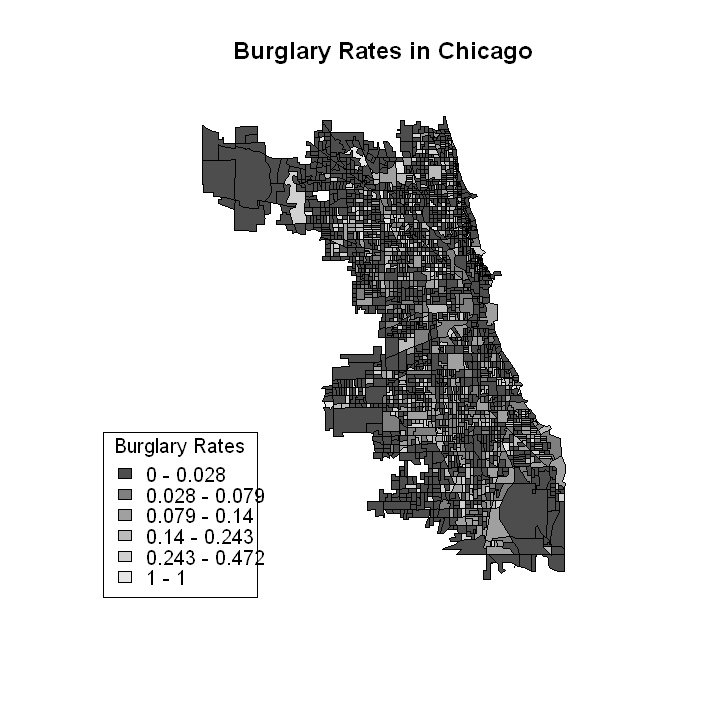

In [106]:
# plot the the rates
plot(chi.subset, col = cols, lwd = 0.2, main = "Burglary Rates in Chicago")

# legend settings
brks <- round(cate$brks, 3)

leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")

legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text, 
          title = "Burglary Rates")

Compute the global Moran test and produce a Moran scatterplot

In [107]:
globalMoran <- moran.test(burgRate, chi.subset.listb, 
                          randomisation = "TRUE", 
                          alternative = "two.sided")

globalMoran


	Moran I test under randomisation

data:  burgRate  
weights: chi.subset.listb  

Moran I statistic standard deviate = 15.792, p-value < 2.2e-16
alternative hypothesis: two.sided
sample estimates:
Moran I statistic       Expectation          Variance 
     1.032627e-01     -2.815315e-04      4.299261e-05 


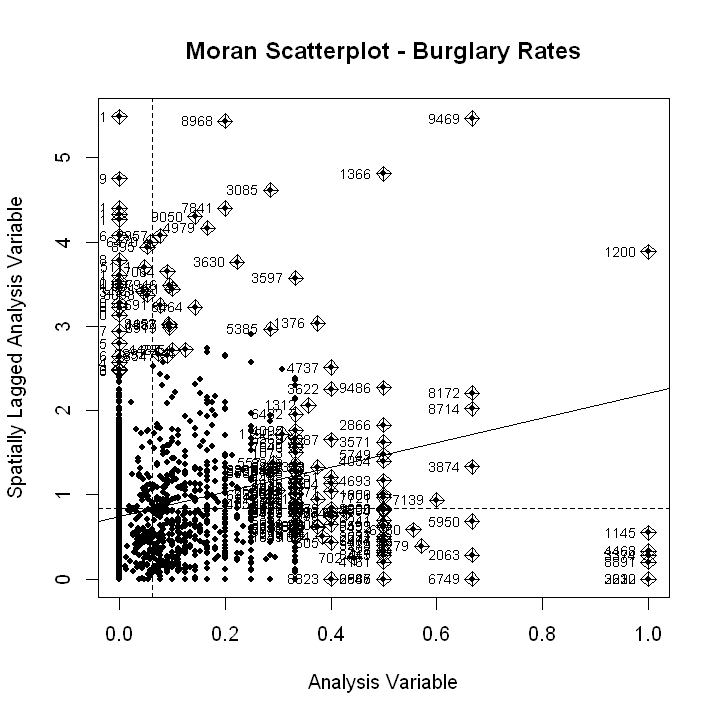

In [108]:
moran.plot(burgRate, chi.subset.listb,
              labels = as.character(chi.subset$TARGET_FID),
              pch = 20, 
              xlab = "Analysis Variable", 
              ylab = "Spatially Lagged Analysis Variable",
              main = "Moran Scatterplot - Burglary Rates")

Conduct a Monte-Carlo simulation of Moran's I using 1700 permutations

In [109]:
moran.mc(burgRate, chi.subset.listb, nsim = 1700)


	Monte-Carlo simulation of Moran I

data:  burgRate 
weights: chi.subset.listb  
number of simulations + 1: 1701 

statistic = 0.10326, observed rank = 1701, p-value = 0.0005879
alternative hypothesis: greater


Compute the global Geary C Test.

In [110]:
geary.test(burgRate, chi.subset.listw)


	Geary C test under randomisation

data:  burgRate 
weights: chi.subset.listw 

Geary C statistic standard deviate = 7.429, p-value = 5.473e-14
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
     0.8982422395      1.0000000000      0.0001876198 


Conduct a Monte-Carlo simulation of Geary C using 900 permutations.

In [111]:
geary.mc(burgRate, chi.subset.listw, nsim = 900)


	Monte-Carlo simulation of Geary C

data:  burgRate 
weights: chi.subset.listw 
number of simulations + 1: 901 

statistic = 0.89824, observed rank = 1, p-value = 0.00111
alternative hypothesis: greater


Compute the global Getis and Ord G statistic

In [112]:
globalG.test(burgRate, chi.subset.listb, 
                zero.policy = NULL, alternative = "two.sided", 
                spChk = NULL, adjust.n = TRUE, 
                B1correct = TRUE)


	Getis-Ord global G statistic

data:  burgRate 
weights: chi.subset.listb 

standard deviate = 11.625, p-value < 2.2e-16
alternative hypothesis: two.sided
sample estimates:
Global G statistic        Expectation           Variance 
      5.355394e-03       3.651907e-03       2.147326e-08 
